In [18]:
import netCDF4 as nc
import pylab as plt
import numpy as np
from mpl_toolkits.basemap import Basemap, shiftgrid
import cf
import cfplot as cfp
import matplotlib
import pandas as pd
import numpy.ma as ma

In [38]:
mr = 16.
var_name = 'ch4'
var_lab = 'CH4'
stash_name = 'field34009'
outfile = '/home/znjs2/output/vertical_profiles'

In [13]:
matplotlib.style.use('test_style')

## Import data

In [4]:
data = nc.Dataset(f'/shared/netscratch/ptg21/UM_data/xltln/xltln_{var_name}.nc')
#extract variables to arrays
ch4 = data.variables[var_name][:]*28/mr*1e9
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
box_no = data.variables['model_level_number'][:]
alt = data.variables['level_height'][:]

time = data.variables['time']
dtime = nc.num2date(time[:],time.units)

#ch4, lon = shiftgrid(180.,ch4,lon,start=False)

In [5]:
data_lbc = nc.Dataset('/shared/netscratch/ptg21/UM_data/xgywn/xgywn_pm7-9.nc')
#extract variables to arrays
ch4_lbc = data_lbc.variables[stash_name][:]*28/mr*1e9
lat_lbc = data_lbc.variables['latitude'][:]
lon_lbc = data_lbc.variables['longitude'][:]
#box_no_lbc = data_lbc.variables['model_level_number'][:]
alt_lbc = data_lbc.variables['hybrid_ht'][:]

time_lbc = data_lbc.variables['t']
dtime_lbc = nc.num2date(time_lbc[:],time_lbc.units)
#ch4_lbc, lon_lbc = shiftgrid(180.,ch4_lbc,lon_lbc,start=False)

## ATom mask

In [19]:
atom_mask = np.load('/home/znjs2/output/vertical_profiles/ATom_lat_lon_mask.npy')[:,:-1]
#add model level dimension to mask
atom_mask_3d = np.repeat(atom_mask[np.newaxis,:,:],60,axis=0)

#time mean
time_mean_xl = np.mean(ch4, axis=(0))
time_mean_xg = np.mean(ch4_lbc, axis=(0))

masked_xl = ma.masked_array(time_mean_xl, atom_mask_3d)
masked_xg = ma.masked_array(time_mean_xg, atom_mask_3d)

## Mean over lon( and time)

In [6]:
#mean over lon
ch4_mean = np.mean(masked_xl,axis=2)
ch4_mean_lbc = np.mean(masked_xg, axis=2)

## Latitude band data

In [25]:
#lat = latitudes, var_mean = variable meaned over lon and time
def lat_bin_data(lat,var_mean):
    lat_bands = np.empty((6,60))
    base = np.zeros(6)
    for i in range(-90,90,30):
        ind1 = list(lat).index(i)
        ind2 = list(lat).index(i+30)
        lat_data = var_mean[:,ind1:ind2]
        lat_mean = np.mean(lat_data, axis=1)
        ind3 = np.int((i+90)/30)
        base[ind3] = lat_mean[0]
        lat_bands[ind3,:] = lat_mean
    return(lat_bands, base)

In [26]:
lat_bands_ch4, base_em = lat_bin_data(lat,ch4_mean)
lat_bands_ch4_lbc, base_lbc = lat_bin_data(lat_lbc,ch4_mean_lbc)

In [22]:
lat_bands_ch4_obs = np.load(f'/home/znjs2/input_data/atom_data_02_20/var_lat_binned/{var_name}_lat_binned.npy')
yvals = np.linspace(0,12000)
base_obs = lat_bands_ch4_obs[0,0]

### Plot vertical profile for CH4 data: annual mean

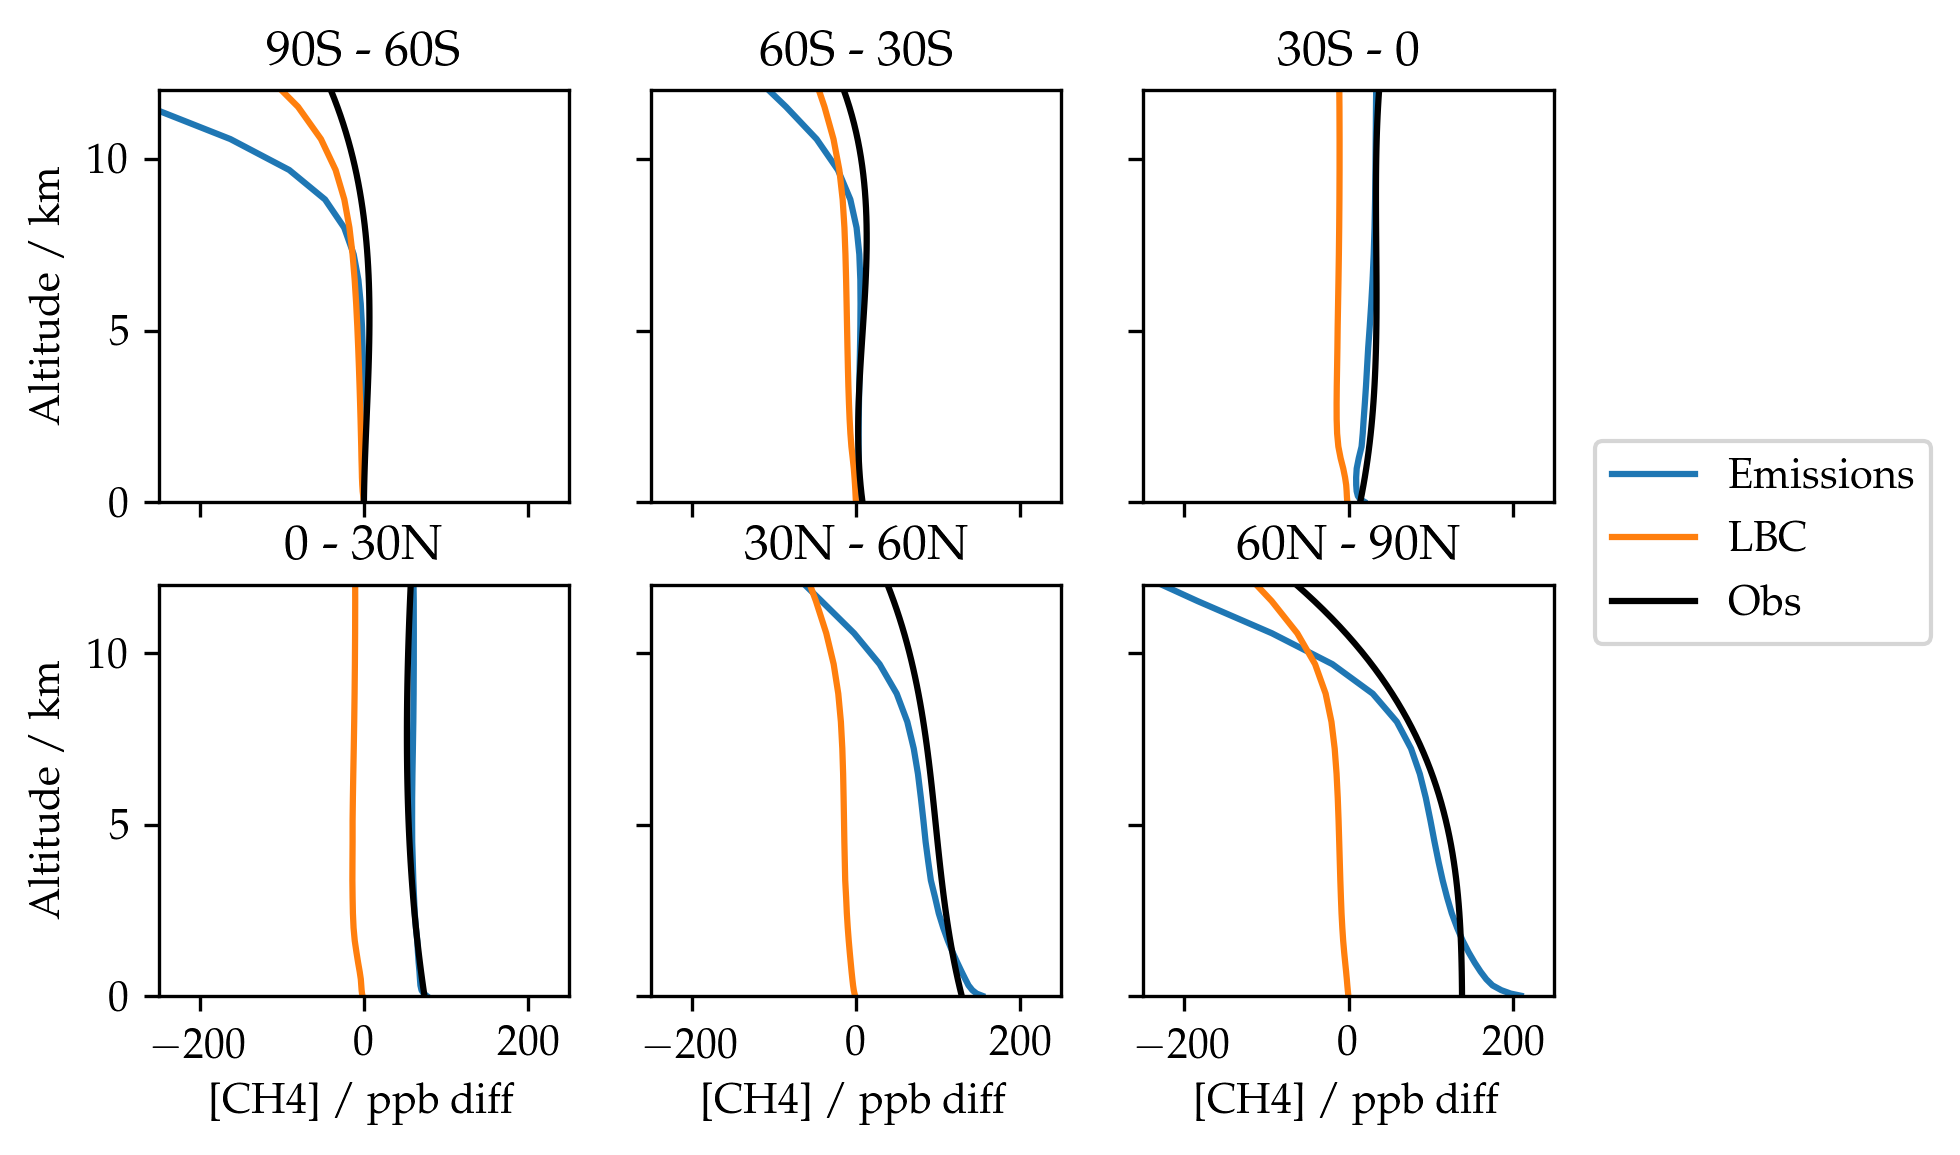

In [27]:
fig = plt.figure(dpi=300)
#ax = plt.axes()

plt_labels=["90S - 60S","60S - 30S","30S - 0","0 - 30N","30N - 60N","60N - 90N"]

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.plot(lat_bands_ch4[i,:] - base_em[0], alt/1000, label=f'Emissions')
    ax.plot(lat_bands_ch4_lbc[i,:] - base_lbc[0], alt_lbc/1000, label=f'LBC')
    ax.plot(lat_bands_ch4_obs[i,:] - base_obs, yvals/1000, c ='k' ,label=f'Obs')
    ax.set_ylim(0,12)
    ax.set_xlim(-250,250) #+- 250 for ch4
    plt.xlabel(f'[{var_lab}] / ppb diff')
    plt.ylabel('Altitude / km')
    plt.title(f'{plt_labels[i]}')
    if i == 5:
        plt.legend(bbox_to_anchor=(1.05,1.4))

for ax in fig.get_axes():
    ax.label_outer()

#for legend for all lines in all subplots
#fig.legend(bbox_to_anchor=(1.1,1))

## Include height of ozonopause

In [28]:
ozone_100_xltln = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_xltln.npy')
ozone_100_xgywn = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_xgywn.npy')

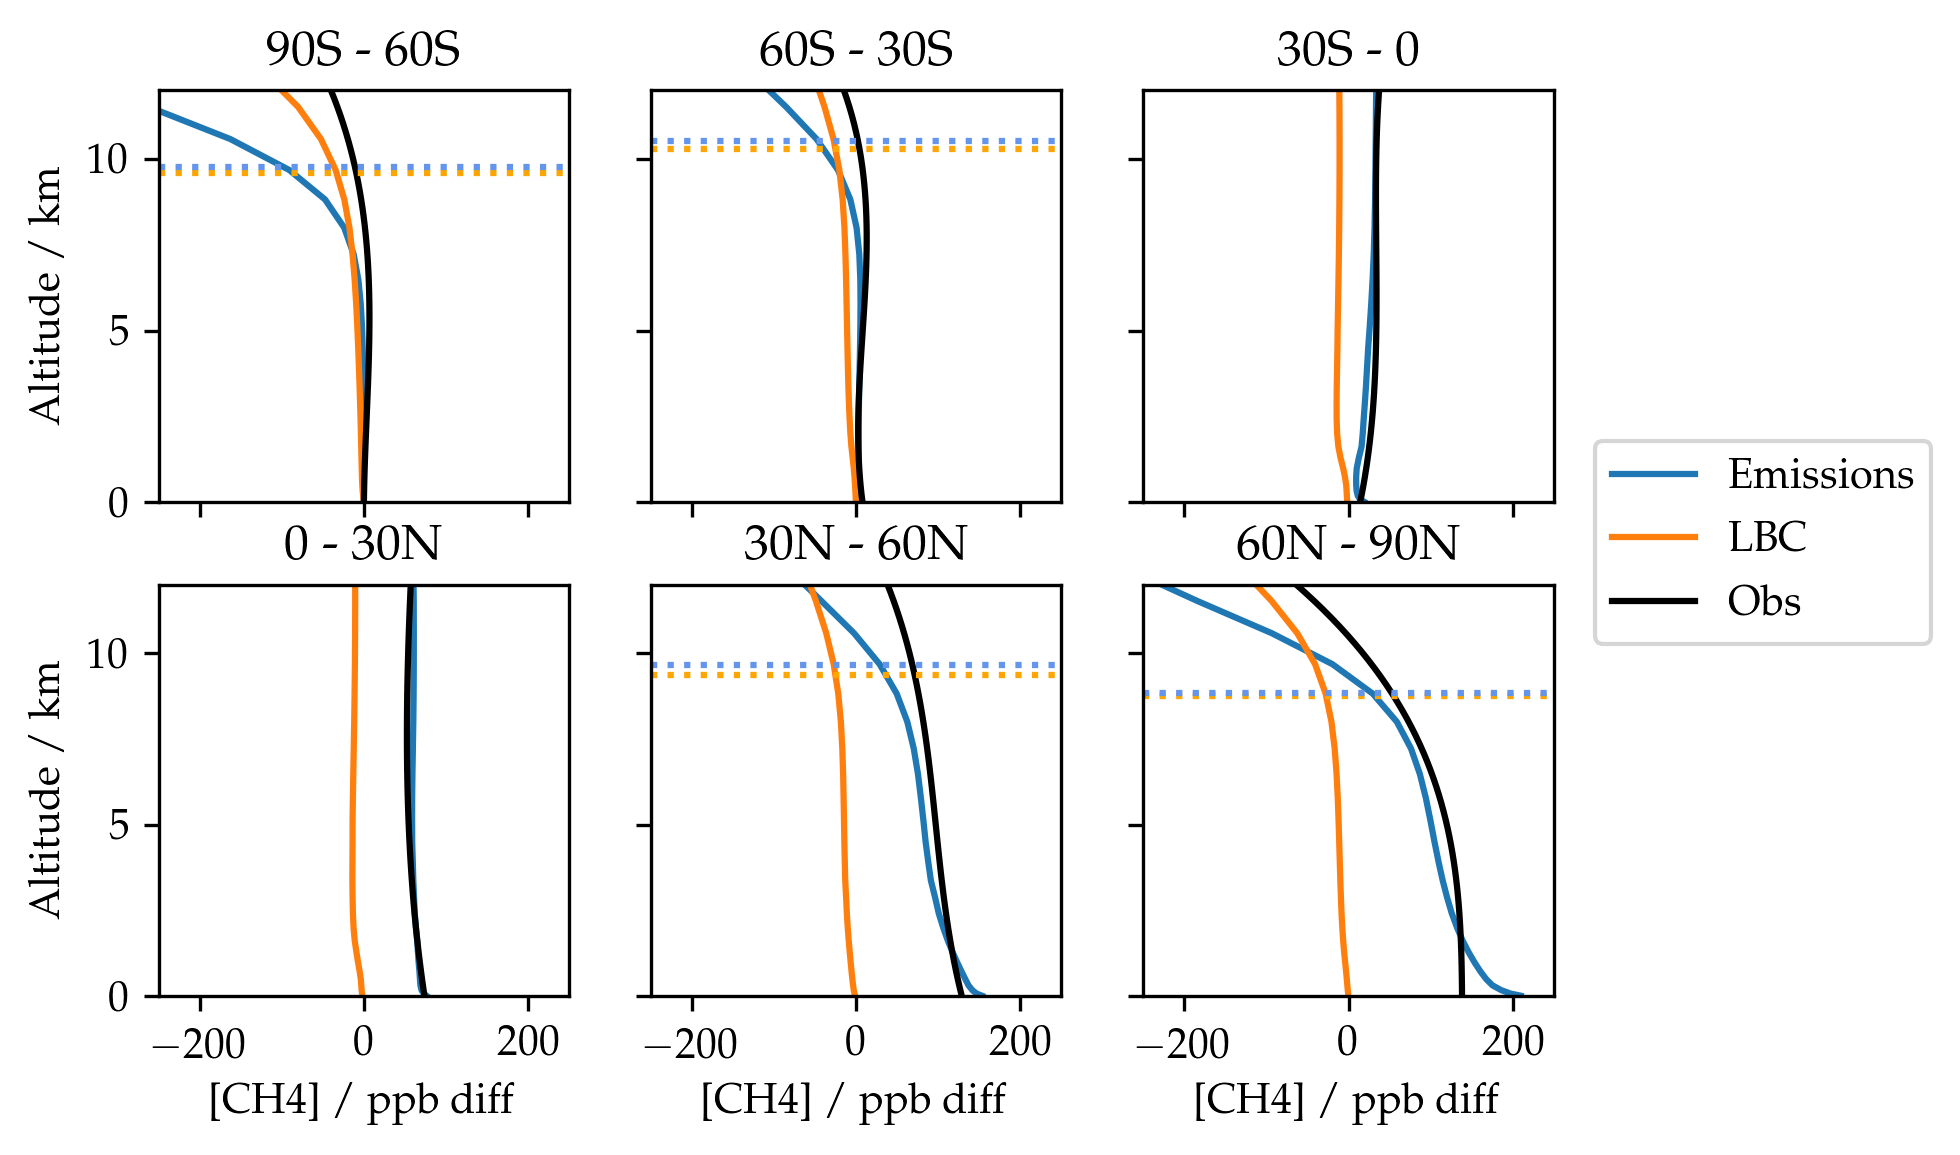

In [30]:
fig = plt.figure(dpi=300)
#ax = plt.axes()

plt_labels=["90S - 60S","60S - 30S","30S - 0","0 - 30N","30N - 60N","60N - 90N"]

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.plot(lat_bands_ch4[i,:] - base_em[0], alt/1000, label=f'Emissions')
    ax.plot(lat_bands_ch4_lbc[i,:] - base_lbc[0], alt_lbc/1000, label=f'LBC')
    ax.plot(lat_bands_ch4_obs[i,:] - base_obs, yvals/1000, c ='k' ,label=f'Obs')
    ax.plot([-250, 250], [ozone_100_xgywn[i], ozone_100_xgywn[i]], 'orange',linestyle=':')
    ax.plot([-250, 250], [ozone_100_xltln[i], ozone_100_xltln[i]], 'cornflowerblue',linestyle=':')
    ax.set_ylim(0,12)
    ax.set_xlim(-250,250)
    plt.xlabel('[CH4] / ppb diff')
    plt.ylabel('Altitude / km')
    plt.title(f'{plt_labels[i]}')
    if i == 5:
        plt.legend(bbox_to_anchor=(1.05,1.4))

for ax in fig.get_axes():
    ax.label_outer()

#for legend for all lines in all subplots
#fig.legend(bbox_to_anchor=(1.1,1))

## Monthly/seasonal analysis

In [31]:
#extract month from datetime object
def get_month(arr):
    months = np.empty((len(arr)))
    for i in range(len(arr)):
        months[i] = arr[i].month
    return months

ch4_xl_months = get_month(dtime)
ch4_xg_months = get_month(dtime_lbc)

In [32]:
#select month
def select_month_data(month,month_list,arr):
    month_indices = []
    jan_ch4 = []
    for i in range(len(month_list)):
        if np.int(month_list[i]) == month:
            month_indices.append(i)
            jan_ch4.append(arr[i,:,:,:])
    return(np.array(jan_ch4))

In [59]:
#change integer to select month
a = 7
b = 8

ch4_a = select_month_data(a,ch4_xl_months,ch4)
ch4_b = select_month_data(b,ch4_xl_months,ch4)
ch4_a_lbc = select_month_data(a,ch4_xg_months,ch4_lbc)
ch4_b_lbc = select_month_data(b,ch4_xg_months,ch4_lbc)
print(ch4_a.shape)

(12, 60, 73, 96)


In [60]:
#seasonal mean from months, over lon and time
ch4_mean = np.mean(np.concatenate((ch4_a,ch4_b)), axis=(0,3))
ch4_mean_lbc = np.mean(np.concatenate((ch4_a_lbc, ch4_b_lbc)), axis=(0,3))

In [61]:
#split by latitude band
lat_bands_ch4_sea, base_em = lat_bin_data(lat, ch4_mean)
lat_bands_ch4_lbc_sea, base_lbc = lat_bin_data(lat_lbc, ch4_mean_lbc)

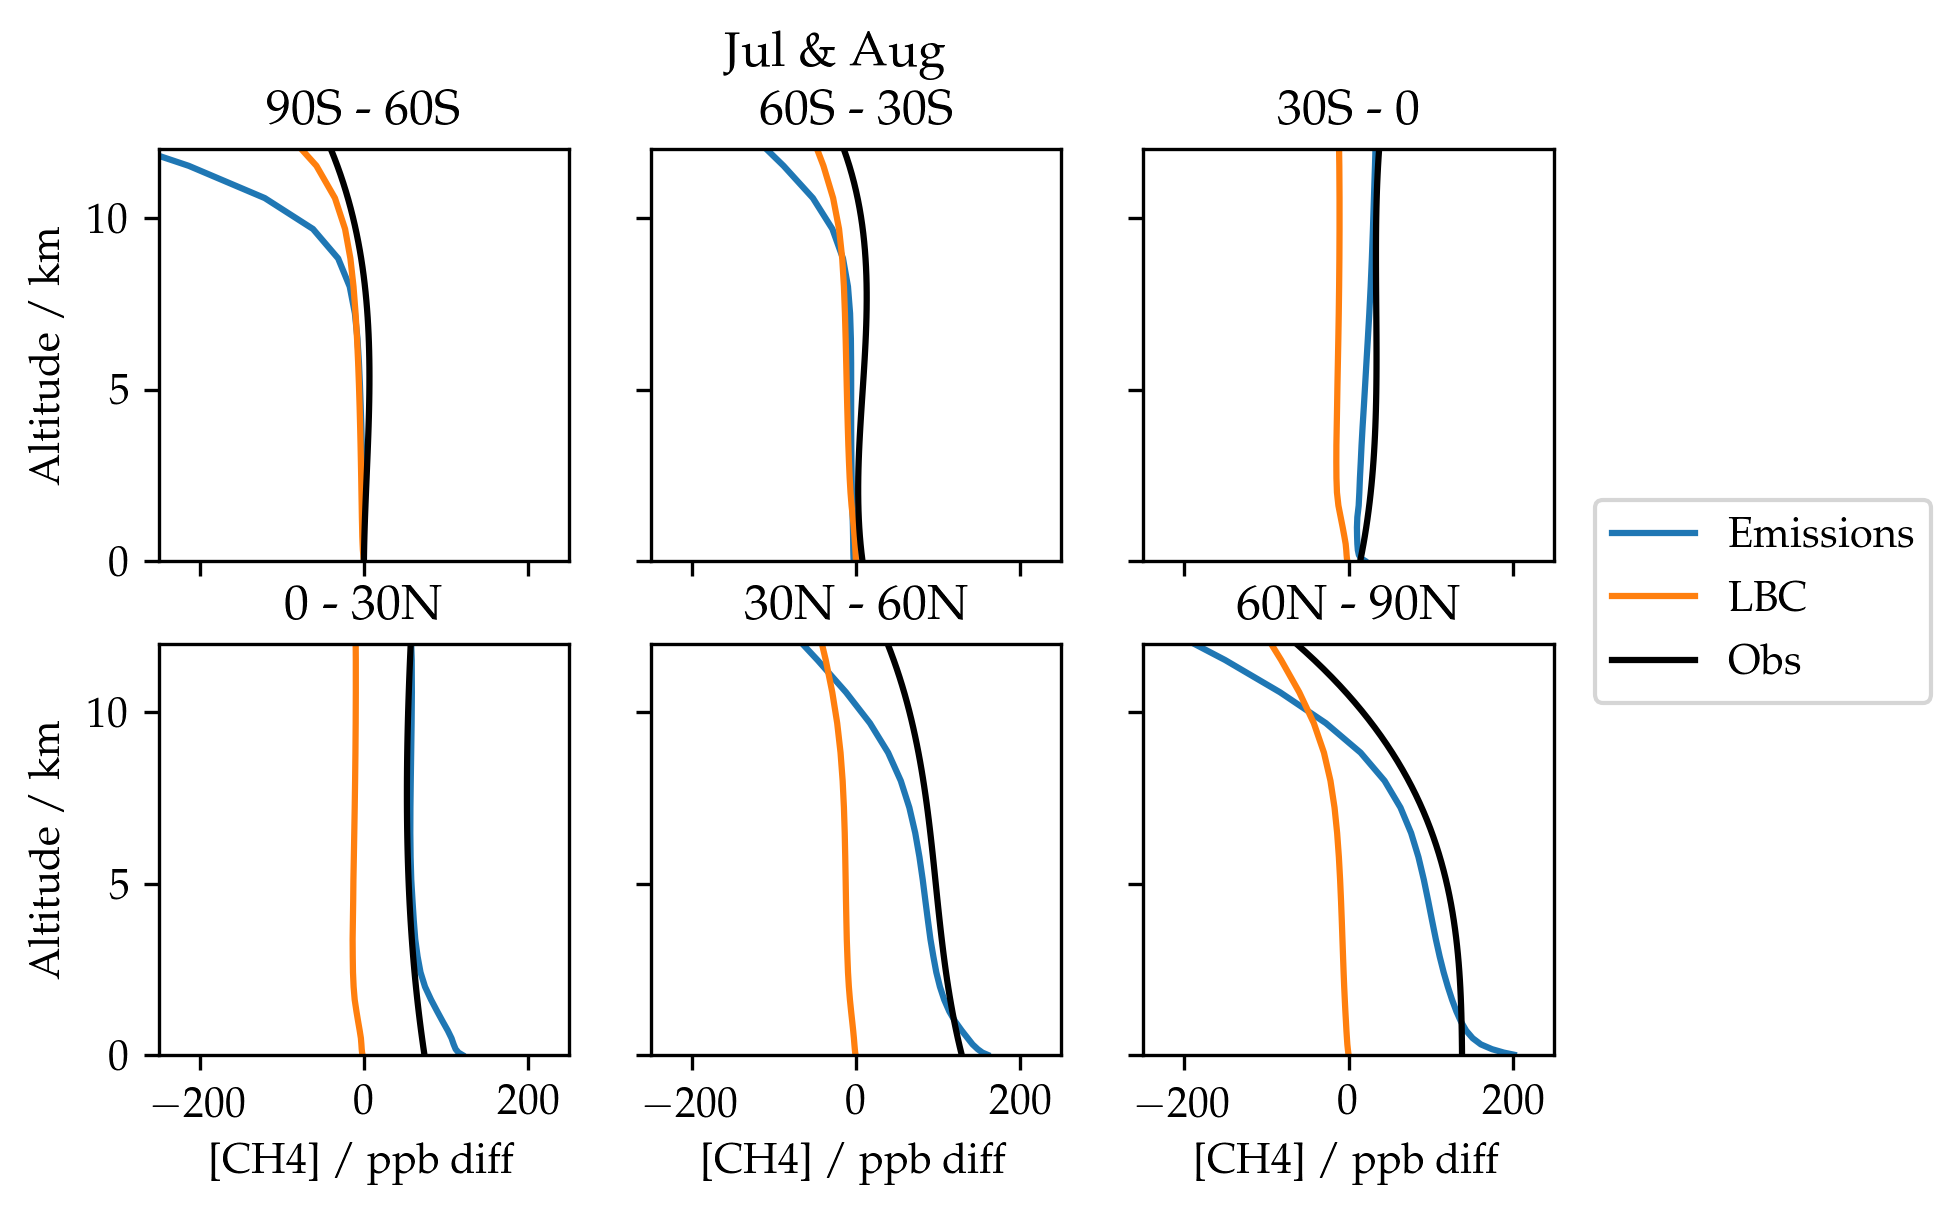

In [62]:
fig = plt.figure(dpi=300)
#ax = plt.axes()

plt_labels=["90S - 60S","60S - 30S","30S - 0","0 - 30N","30N - 60N","60N - 90N"]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.plot(lat_bands_ch4_sea[i,:] - base_em[0], alt/1000, label=f'Emissions')
    ax.plot(lat_bands_ch4_lbc_sea[i,:] - base_lbc[0], alt_lbc/1000, label=f'LBC')
    ax.plot(lat_bands_ch4_obs[i,:] - base_obs, yvals/1000, c ='k' ,label=f'Obs')
    #ax.plot([-250, 250], [ozone_100_xgywn_JF[i], ozone_100_xgywn_JF[i]], 'orange',linestyle=':')
    #ax.plot([-250, 250], [ozone_100_xltln_JF[i], ozone_100_xltln_JF[i]], 'cornflowerblue',linestyle=':')
    ax.set_ylim(0,12)
    ax.set_xlim(-250,250)
    plt.xlabel(f'[{var_lab}] / ppb diff')
    plt.ylabel('Altitude / km')
    plt.title(f'{plt_labels[i]}')
    if i == 5:
        plt.legend(bbox_to_anchor=(1.05,1.4))

for ax in fig.get_axes():
    ax.label_outer()

fig.suptitle(f'{months[a-1]} \& {months[b-1]}')
#for legend for all lines in all subplots
#fig.legend(bbox_to_anchor=(1.1,1))
plt.savefig(f'{outfile}/{var_name}_vert_prof_{months[a-1]}_{months[b-1]}.png')

## Ozonopause monthly

In [56]:
ozone_100_xltln_JF = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_xltln_JF.npy')
ozone_100_xltln_JA = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_xltln_JA.npy')

ozone_100_xgywn_JF = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_xgywn_JF.npy')
ozone_100_xgywn_JA = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_xgywn_JA.npy')

ozone_100_ATom_JF = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_ATom_JF.npy')
ozone_100_ATom_JA = np.load('/shared/netscratch/znjs2/ch4_prof_data/alt_ozone_100_ATom_JA.npy')

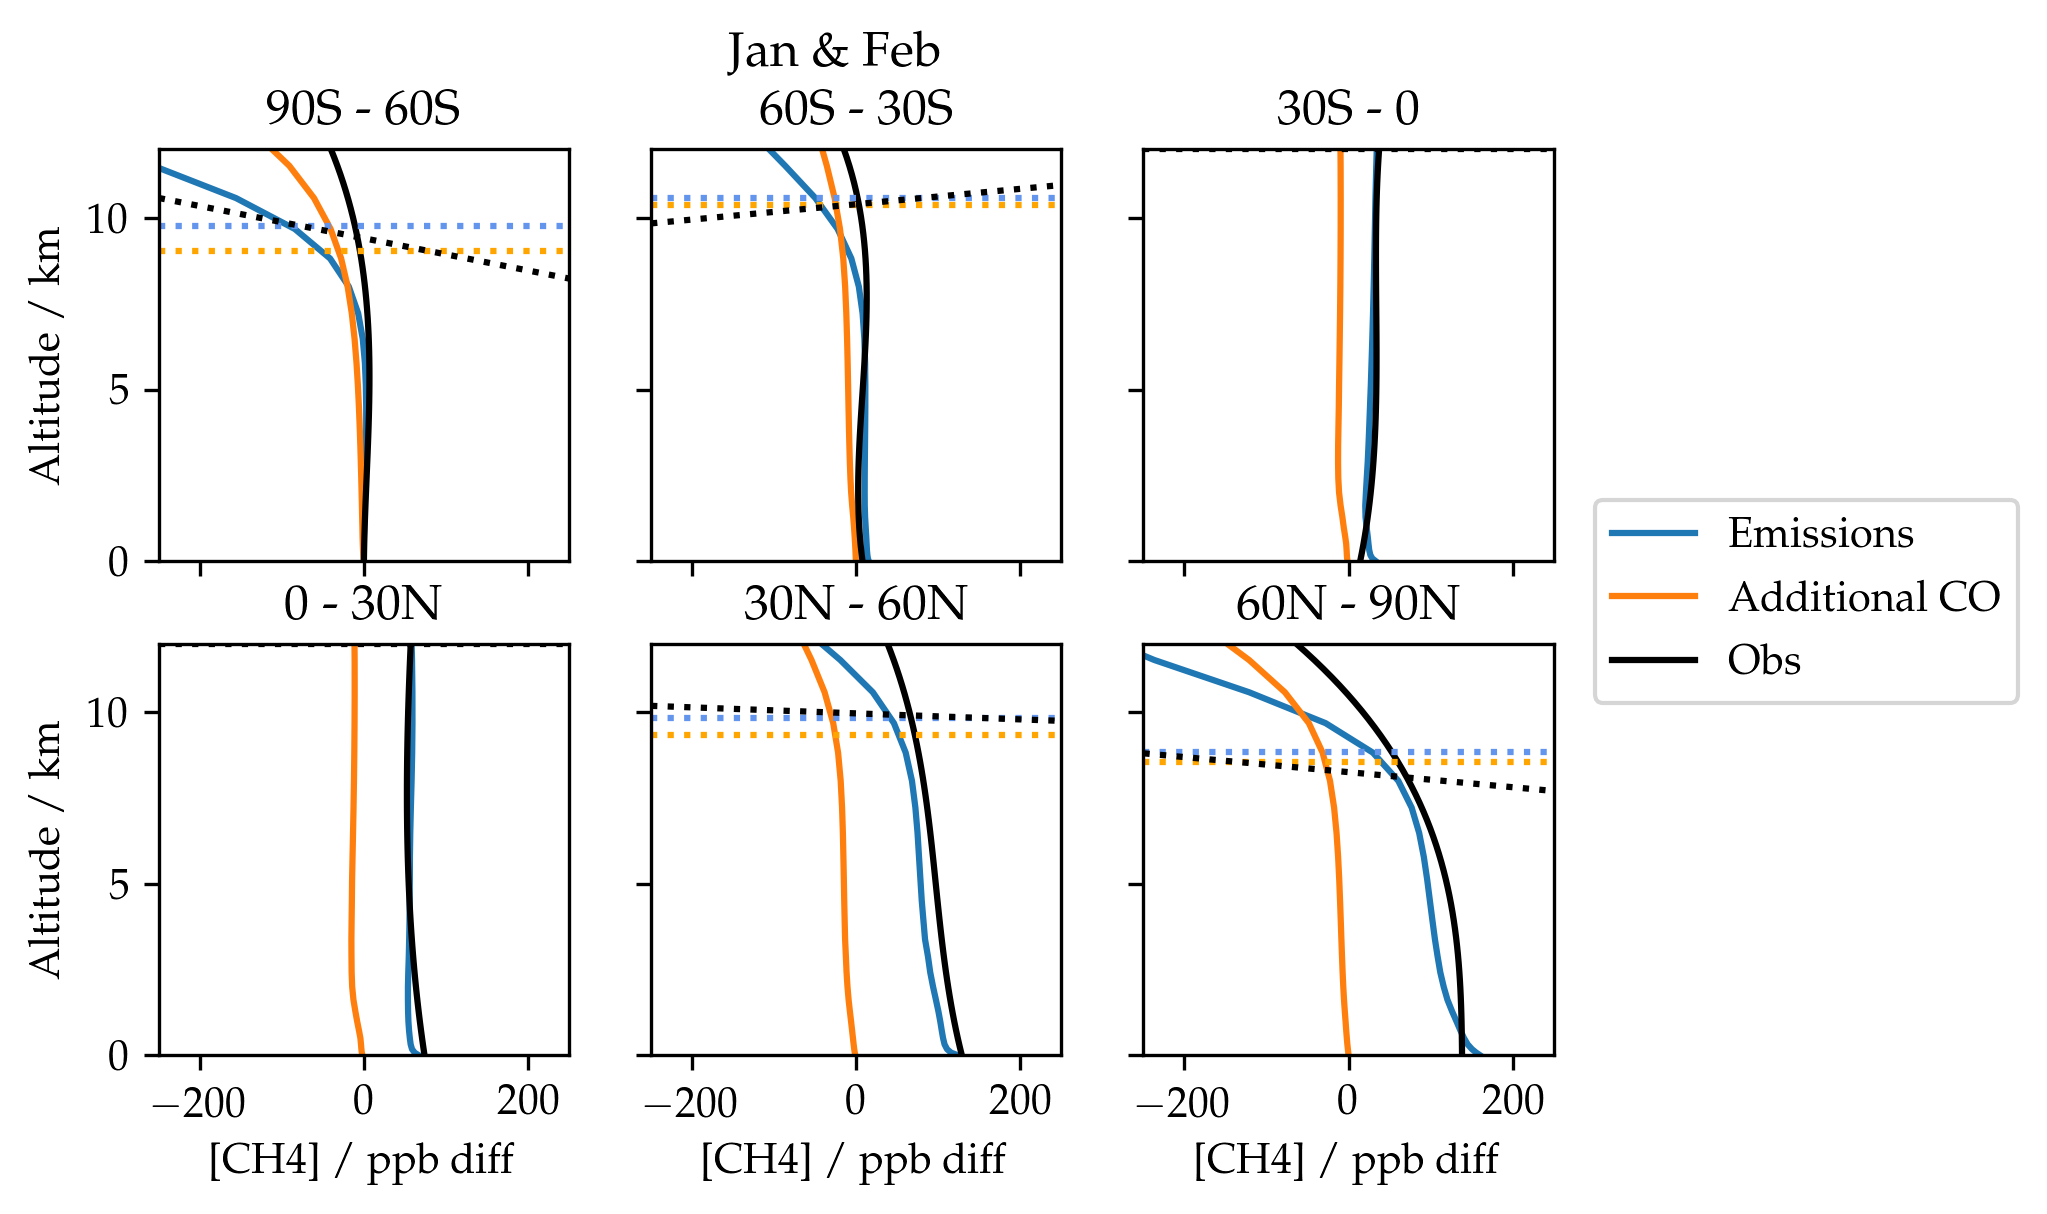

In [57]:
#*****Change ozonopause input variable to correct month^!
fig = plt.figure(dpi=300)
#ax = plt.axes()

plt_labels=["90S - 60S","60S - 30S","30S - 0","0 - 30N","30N - 60N","60N - 90N"]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for i in range(6):
    ax = plt.subplot(2,3,i+1)
    ax.plot(lat_bands_ch4_sea[i,:] - base_em[0], alt/1000, label=f'Emissions')
    ax.plot(lat_bands_ch4_lbc_sea[i,:] - base_lbc[0], alt_lbc/1000, label=f'Additional CO')
    ax.plot(lat_bands_ch4_obs[i,:] - base_obs, yvals/1000, c ='k' ,label=f'Obs')
    ax.plot([-250, 250], [ozone_100_xgywn_JF[i], ozone_100_xgywn_JF[i]], 'orange',linestyle=':')
    ax.plot([-250, 250], [ozone_100_xltln_JF[i], ozone_100_xltln_JF[i]], 'cornflowerblue',linestyle=':')
    ax.plot([-250, 250], [ozone_100_ATom_JA[i], ozone_100_ATom_JF[i]], 'k',linestyle=':') 
    ax.set_ylim(0,12)
    ax.set_xlim(-250,250)
    plt.xlabel(f'[{var_lab}] / ppb diff')
    plt.ylabel('Altitude / km')
    plt.title(f'{plt_labels[i]}')
    if i == 5:
        plt.legend(bbox_to_anchor=(1.05,1.4))

for ax in fig.get_axes():
    ax.label_outer()

fig.suptitle(f'{months[a-1]} \& {months[b-1]}')
#for legend for all lines in all subplots
#fig.legend(bbox_to_anchor=(1.1,1))
plt.savefig(f'{outfile}/{var_name}_vert_prof_{months[a-1]}_{months[b-1]}.png')